# S Supplementary Material

This Jupyter Notebook contains an algorithm to generate a circuit which prepares the generalized Dicke states and an example of usage.


After Submissen we will publish this notebook on Git Hub.

## S.1 Preparing Generalized Dicke States

In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_distribution, state_visualization
from qiskit.circuit.library import RYGate
from qiskit.quantum_info import Statevector
from IPython.display import Latex

Now we start to introduce the different Gates and Unitaries as in the paper.

### Rotation Gate (Definition 8) 

**input:** $num$ - numerator, $den$ - denominator

**output:** rotation gate  $\boxed{\sqrt{num/den}}$

In [2]:
def ry_gate(num, den):
    return RYGate(2*np.arccos(np.sqrt(num/den)),label=str(num)+ '/'+str(den))

### The unitary SCS (implemented as in Theorem 10 and stated in PrepareAncAndSwap)

**input:** $n$ - vector length, $k$ - Hamming weight, <br>
$q$ - number of qubits per vector component, <br>
$\texttt{circ}$ - quantum circuit, $\texttt{qr}$ - quantum register, $\texttt{anc}$ - ancilla qubits, <br>
$\texttt{qr}_{offset}$ - clarifies on which registers of $\texttt{qr}$ the swap-algorithm should be applied, <br>
$\texttt{anc}_{offset}$ - clarifies which ancilla qubits the swap-algorithm should use, <br>
$\texttt{measurement}$ - boolean that turns the measurement of $\texttt{anc}$ on/off <br>
        
**output:** $SCS$-unitary for the given parameters<br>

Our implementation provides the boolean $\texttt{measurement}$ to turn the measurement of $\texttt{anc}$ on and off.
This is necessary for the analysis since some of qiskit's functionalities insist on "unmeasured" qubits.


In [3]:
def SCS(n,k,circ,qr,anc,cl_anc,qr_offset,anc_offset,q, measurement = True):
    # Prepare the first ancilla qubit (Line 3 of PrepareAncAndSwap).
    circ.append(ry_gate(n-1,n),[anc[anc_offset]])
    for j in range(q):
        circ.cswap(anc[anc_offset], qr[qr_offset + j], qr[qr_offset + j + 2], ctrl_state='0')
    for i in range(k-2):
        # Prepare the next ancilla qubit (Line 6,7 of PrepareAncAndSwap).
        circ.cx(anc[anc_offset + i],anc[anc_offset + i+1])
        circ.append(ry_gate(n-i-2,n-i-1).control(1, ctrl_state='0'),[anc[anc_offset + i],anc[anc_offset +1+ i]])
        for j in range(q):
            # Next line corresponds to Line 4 of PrepareAncAndSwap
            circ.cswap(anc[anc_offset +1 + i], qr[qr_offset + j], qr[qr_offset + j +2*(i + 1) + 2], ctrl_state='0')
        if (measurement == True):
            # Measure the "used" ancilla qubits (Line 9 of PrepareAncAndSwap)
            circ.measure(anc[anc_offset + i], cl_anc[anc_offset + i])
    if (measurement == True):
        circ.measure(anc[anc_offset + k - 2], cl_anc[anc_offset + k - 2])
    return circ

## S.2 Example of Usage

In the following we show an example of usage, how to prepare a generalized 4-dimensional Dicke state with $q=2$. <br>
Feel free to change the initial state by adjusting the parameter $\ell_1$, $\ell_2$ and $\ell_3$.

In [4]:
n = 4
k = 4
ell_1 = 2
ell_2 = 0
ell_3 = 1

if (k < ell_1 + ell_2 + ell_3):
    print("You've chosen the wrong parameter!")
    print("The Hamming weight of the vector is bigger than k!")

Hence we want to build an equal superposition over a set with
$\binom{n}{\ell_1,\ell_2,\ell_3} = \binom{4}{2,0,1} = 12$ elements, where each of the vectors has probability $1/12$.

However, the number of required ancilla qubits needs to be known in advance for preparing the Dicke state. <br>

In proof of Theorem 12 we derived the formula:<br>
\# Needed-Qubits $= (n-k)k + \sum\limits_{i=1}^{k-1} i$.


**input:** $n$ - vector length, $k$ - Hamming weight

**output:** number of needed ancilla qubits of $U_{q\cdot n,k}$

In [5]:
def number_anc(n,k):
    result = (n-k)*(k)
    for i in range(k):
        result += i
    return result

Prepare the initial state $\ket{x}$ according to the parameter $\ell_1,\ell_2,\ell_3$.

In [6]:
init = ''
for i in range(n - ell_1 - ell_2 - ell_3):
    init += '00'
for i in range(ell_1):
    init += '01'
for i in range(ell_2):
    init += '10'
for i in range(ell_3):
    init += '11'

Build the test circuit: <br> 

(1) Prepare the needed quantum register for the Dicke state $\texttt{qr}$ and for the ancilla qubits $\texttt{anc}$, <br>
as well as the corresponding classical register $\texttt{cl\_qr}$ and $\texttt{cl\_anc}$ for the measurement at the end.

(2) Apply the unitary $\mathcal{U}_{2\cdot 4,4} = (SCS_{q\cdot 2,1}\otimes Id^{\otimes 4})\cdot (SCS_{q\cdot 3,2}\otimes Id^{\otimes 2})\cdot SCS_{q\cdot 4,3}$ (Lemma 7) to prepare the Dicke state $\ket{\mathcal{D}^{2\cdot 4}_{\ell_1,\ell_2,\ell_3}}$.


Again, our test circuit provides a boolean parameter $\texttt{measurement}$ to turn the measurement of $\texttt{qr}$ and $\texttt{anc}$ on and off.<br>


In [7]:
def build_circuit(measurement):
    qr = QuantumRegister(2*n, 'qr')
    anc = QuantumRegister(number_anc(n,k), 'anc')
    # Classical register for measurements
    cl_qr = ClassicalRegister(2*n, 'c-qr')
    cl_anc = ClassicalRegister(number_anc(n,k), 'c-anc')
    circ = QuantumCircuit(qr, anc, cl_qr, cl_anc)
    # Intialize the register qr with init = |x>.
    circ.initialize(init, qr[:])
    # Set anc_offset
    anc_offset=0
    for i in range(n-1):
        circ = SCS(n-i, np.minimum(k+1, n-i),circ, qr, anc, cl_anc, 2*i, anc_offset, 2, measurement=measurement)
        # Update anc_offset, and use "fresh" ancilla qubits in the next iteration
        anc_offset += np.minimum(k, n-1-i)
    if (measurement == True):
        for i in range(2*n):
            circ.measure(qr[i],cl_qr[i])
    return circ

## S.2.1 Build the Circuit and Compute the Statevector

In [8]:
circ = build_circuit(measurement = False)

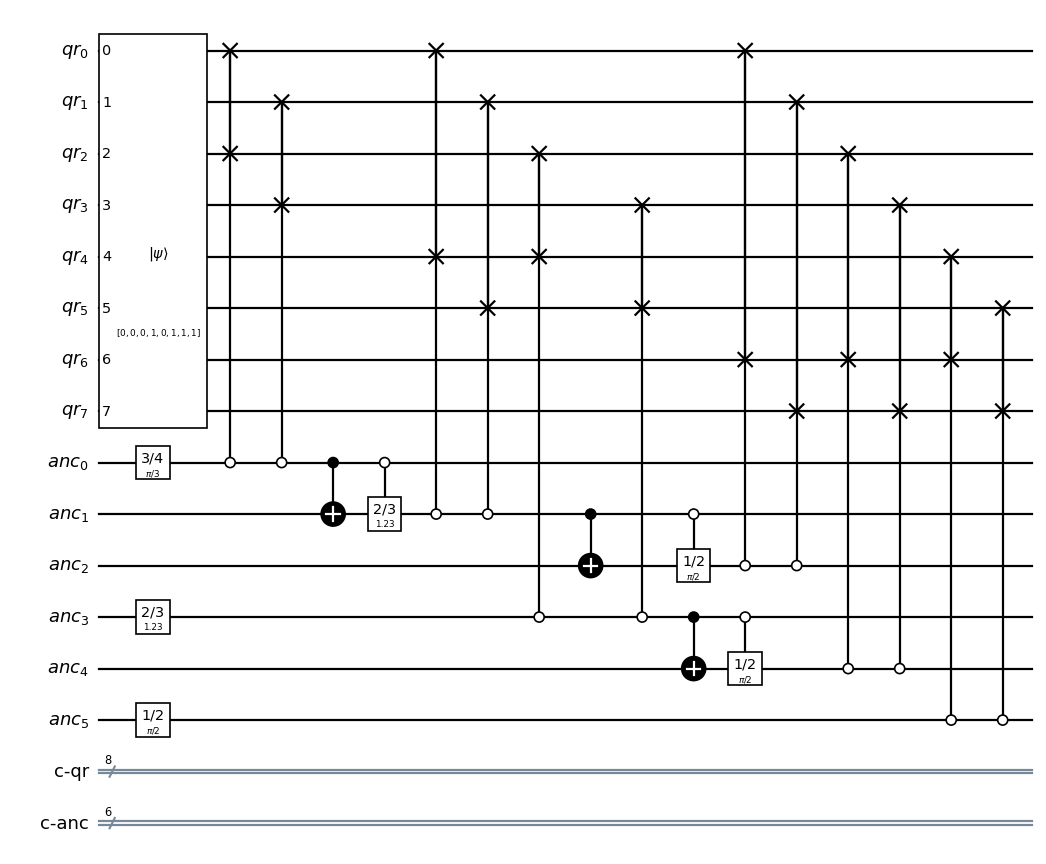

In [9]:
circ.draw('mpl', cregbundle = True, reverse_bits=False, scale=0.8, style = "bw")

In [10]:
state = Statevector.from_int(0, 2**(2*n+number_anc(n,k)))
state = state.evolve(circ)
state_to_latex = state_visualization._state_to_latex_ket(state.data, max_size = 256)
Latex("$" + state_to_latex + "$")

<IPython.core.display.Latex object>

The result register contains the quantum register $\texttt{qr}$ and $\texttt{anc}$ so that we can ignore the first 6 qubits in each term. We are only interested in the last 8 qubits which contains the Dicke state (in $\texttt{qr}$). <br>
Each of the vectors - containing $(\ell_i)$ many $i$-entries, $i=1,2,3$ - is twice in the state, so each of this vectors has - as expected - the amplitude $\sqrt{ (\frac{\sqrt{6}}{12})^2 + (\frac{\sqrt{6}}{12})^2 } = \frac{\sqrt{12}}{12} = \frac{1}{\sqrt{12}}$ and the probability $\frac{1}{12}$.

## S.2.2 Build the Circuit and Measure the Statevector

Note that the result of the experiment is not "perfect", since we can not run the circuit infinitely often.

In [11]:
circ = build_circuit(measurement = True)

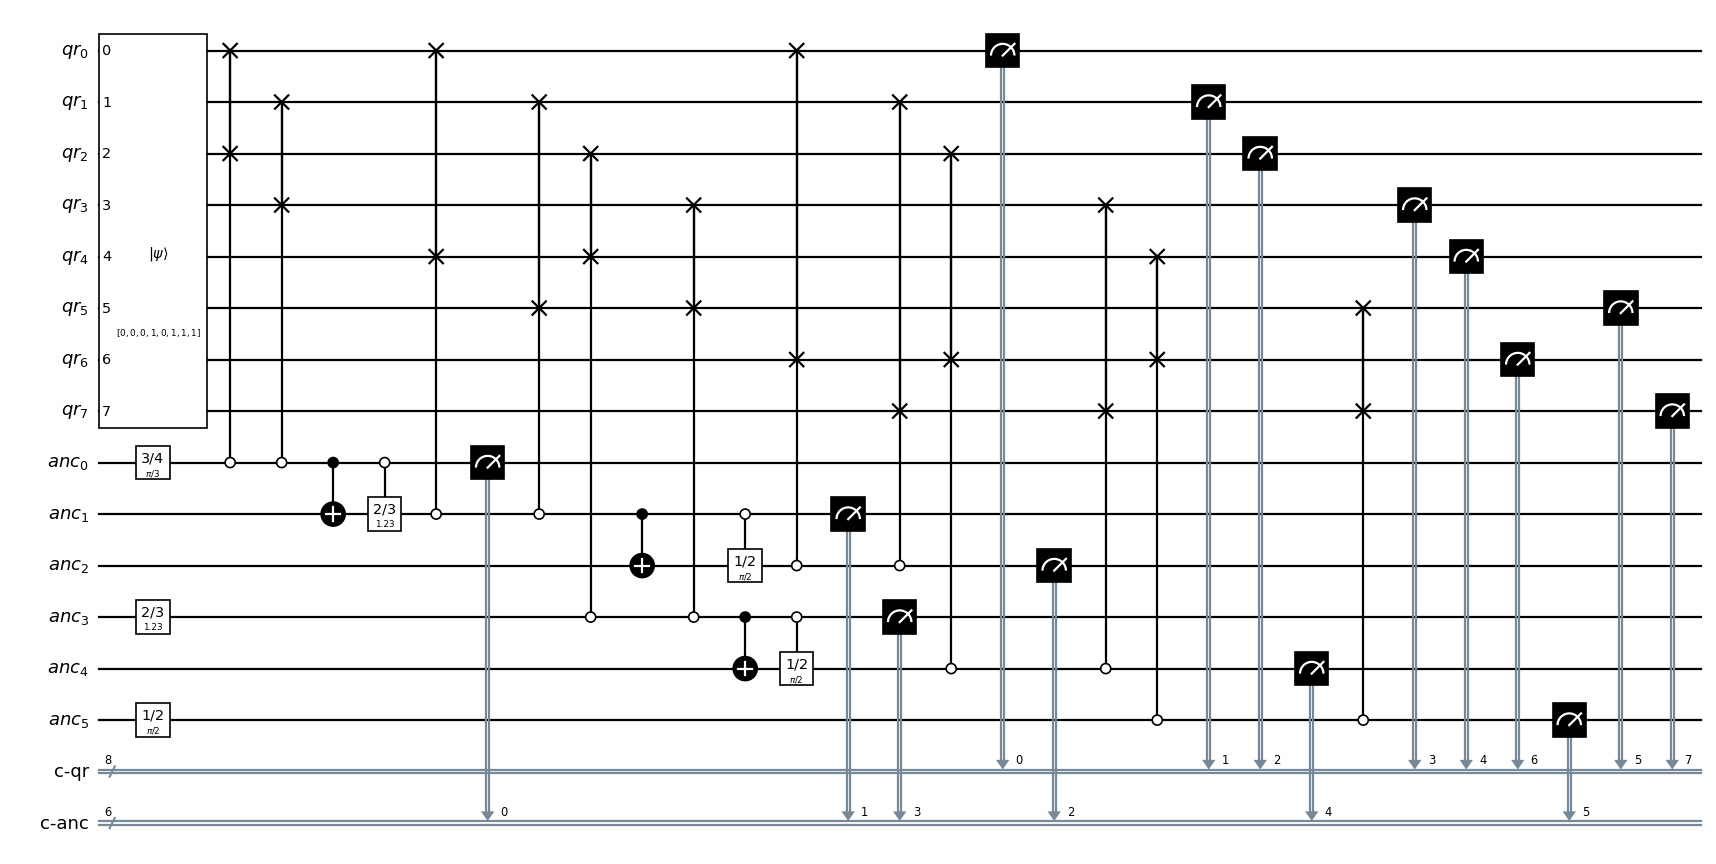

In [12]:
circ.draw('mpl', cregbundle = True, reverse_bits=False, scale=0.8, fold = 32, style = "bw")

The following code snippet builds and measures the circuit 25,000 - times.<br>
Again, the result contains the quantum register $\texttt{qr}$ and $\texttt{anc}$ and we only consider the last 8 qubits which contains the Dicke state.
Each of the vectors - containing $(\ell_i)$ many $i$-entries, $i=1,2,3$ - is twice in the histogram, so each of this vectors has - as expected - the (quasi-)probability $\frac{1}{12} \approx 0.0833$.

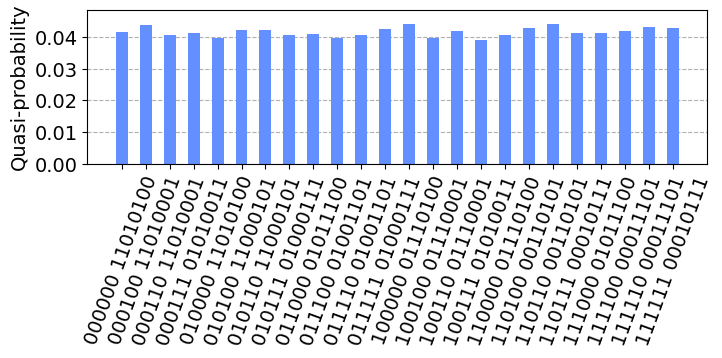

In [13]:
# shots - number of experiment repetitions:
job = execute(circ, backend=Aer.get_backend('qasm_simulator'), shots=25000)
result = job.result()
count = result.get_counts(circ)
plot_distribution(count, figsize=(8,2), bar_labels=False)